In [ ]:
!pip -q install missingno shap lightgbm xgboost optuna


In [ ]:
# -------------------------------
# STEP 1: IMPORT LIBRARIES
# -------------------------------
import warnings, gc, os
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from datetime import datetime
from IPython.display import display

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Set theme & options
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 200)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# -------------------------------
# STEP 2: LOAD DATA
# -------------------------------
df = pd.read_csv(r"C:\Users\Devraj Singh\Desktop\ml project\IPL.csv")
print("Raw Shape:", df.shape)
display(df.head())
print(df.columns)

Raw Shape: (278205, 64)


,Unnamed: 0,match_id,date,match_type,event_name,innings,batting_team,bowling_team,over,ball,ball_no,batter,bat_pos,runs_batter,balls_faced,bowler,valid_ball,runs_extras,runs_total,runs_bowler,runs_not_boundary,extra_type,non_striker,non_striker_pos,wicket_kind,player_out,fielders,runs_target,review_batter,team_reviewed,review_decision,umpire,umpires_call,player_of_match,match_won_by,win_outcome,toss_winner,toss_decision,venue,city,day,month,year,season,gender,team_type,superover_winner,result_type,method,balls_per_over,overs,event_match_no,stage,match_number,team_runs,team_balls,team_wicket,new_batter,batter_runs,batter_balls,bowler_wicket,batting_partners,next_batter,striker_out
0,131970,335982,4/18/2008,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,0.1,SC Ganguly,1,0,1,P Kumar,1,1,1,0,False,legbyes,BB McCullum,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,BB McCullum,Kolkata Knight Riders,140 runs,Royal Challengers Bangalore,field,M Chinnaswamy Stadium,Bangalore,18,4,2008,2007/08,male,club,NaN,NaN,NaN,6,20,1,Unknown,Unknown,1,1,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
1,131971,335982,4/18/2008,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,0.2,BB McCullum,2,0,1,P Kumar,1,0,0,0,False,NaN,SC Ganguly,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,BB McCullum,Kolkata Knight Riders,140 runs,Royal Challengers Bangalore,field,M Chinnaswamy Stadium,Bangalore,18,4,2008,2007/08,male,club,NaN,NaN,NaN,6,20,1,Unknown,Unknown,1,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
2,131972,335982,4/18/2008,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,0.3,BB McCullum,2,0,0,P Kumar,0,1,1,1,False,wides,SC Ganguly,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,BB McCullum,Kolkata Knight Riders,140 runs,Royal Challengers Bangalore,field,M Chinnaswamy Stadium,Bangalore,18,4,2008,2007/08,male,club,NaN,NaN,NaN,6,20,1,Unknown,Unknown,2,2,0,NaN,0,1,0,"('BB McCullum', 'SC Ganguly')",NaN,False
3,131973,335982,4/18/2008,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,0.3,BB McCullum,2,0,1,P Kumar,1,0,0,0,False,NaN,SC Ganguly,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,BB McCullum,Kolkata Knight Riders,140 runs,Royal Challengers Bangalore,field,M Chinnaswamy Stadium,Bangalore,18,4,2008,2007/08,male,club,NaN,NaN,NaN,6,20,1,Unknown,Unknown,2,3,0,NaN,0,2,0,"('BB McCullum', 'SC Ganguly')",NaN,False
4,131974,335982,4/18/2008,T20,Indian Premier League,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,0.4,BB McCullum,2,0,1,P Kumar,1,0,0,0,False,NaN,SC Ganguly,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,BB McCullum,Kolkata Knight Riders,140 runs,Royal Challengers Bangalore,field,M Chinnaswamy Stadium,Bangalore,18,4,2008,2007/08,male,club,NaN,NaN,NaN,6,20,1,Unknown,Unknown,2,4,0,NaN,0,3,0,"('BB McCullum', 'SC Ganguly')",NaN,False


Index(['Unnamed: 0', 'match_id', 'date', 'match_type', 'event_name', 'innings',
       'batting_team', 'bowling_team', 'over', 'ball', 'ball_no', 'batter',
       'bat_pos', 'runs_batter', 'balls_faced', 'bowler', 'valid_ball',
       'runs_extras', 'runs_total', 'runs_bowler', 'runs_not_boundary',
       'extra_type', 'non_striker', 'non_striker_pos', 'wicket_kind',
       'player_out', 'fielders', 'runs_target', 'review_batter',
       'team_reviewed', 'review_decision', 'umpire', 'umpires_call',
       'player_of_match', 'match_won_by', 'win_outcome', 'toss_winner',
       'toss_decision', 'venue', 'city', 'day', 'month', 'year', 'season',
       'gender', 'team_type', 'superover_winner', 'result_type', 'method',
       'balls_per_over', 'overs', 'event_match_no', 'stage', 'match_number',
       'team_runs', 'team_balls', 'team_wicket', 'new_batter', 'batter_runs',
       'batter_balls', 'bowler_wicket', 'batting_partners', 'next_batter',
       'striker_out'],
      dtype='object')

In [ ]:
# -------------------------------
# STEP 3: DATA CLEANING & PREPROCESSING
# -------------------------------
# Drop unnamed index column if present
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Convert date to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Normalize strings
def norm_str(x):
    if pd.isna(x): return x
    return str(x).strip()

for c in ['batting_team','bowling_team','venue','city','toss_winner','toss_decision','match_won_by']:
    if c in df.columns:
        df[c] = df[c].apply(norm_str)


In [ ]:
# -------------------------------
# STEP 4: CREATE CSK-SPECIFIC DATASET
# -------------------------------
CSK = "Chennai Super Kings"
df['csk_involved'] = ((df.get('batting_team') == CSK) | (df.get('bowling_team') == CSK)).astype(int)
df_csk = df[df['csk_involved']==1].copy()
print("Rows where CSK involved:", df_csk.shape)


Rows where CSK involved: (60606, 64)


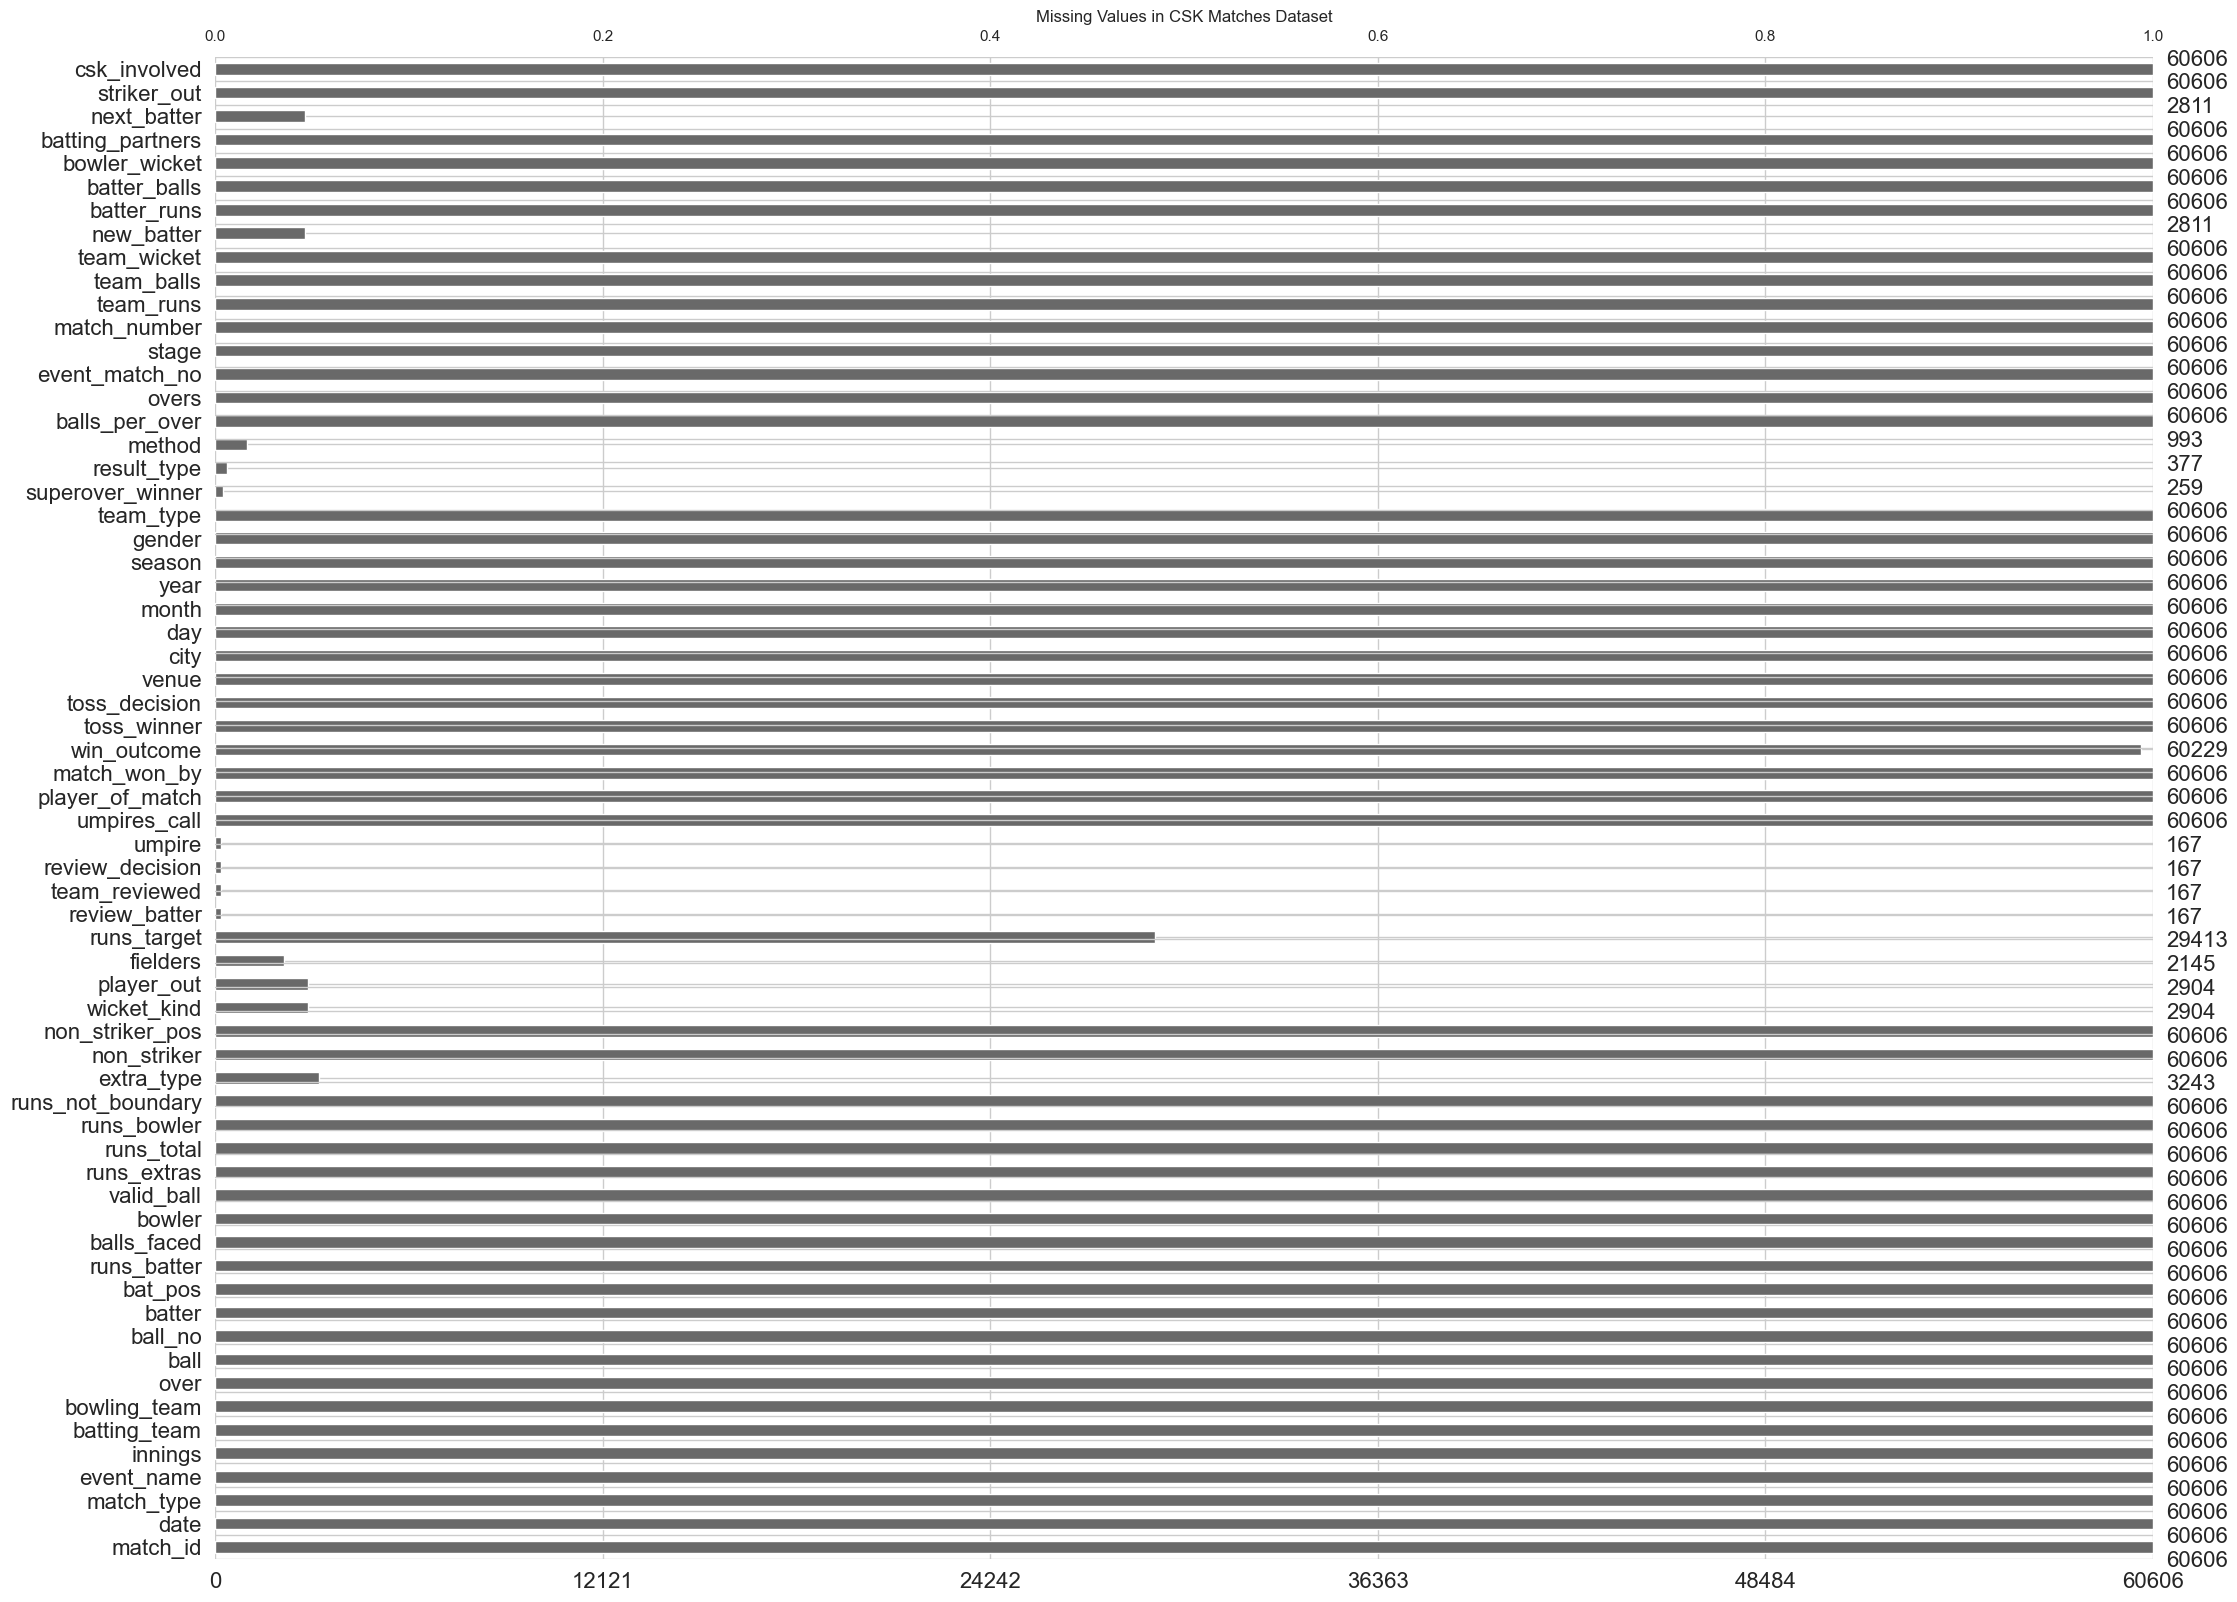

In [ ]:
# -------------------------------
# STEP 5: MISSING VALUE ANALYSIS
# -------------------------------
plt.figure(figsize=(12,5))
msno.bar(df_csk)
plt.title("Missing Values in CSK Matches Dataset")
plt.show()

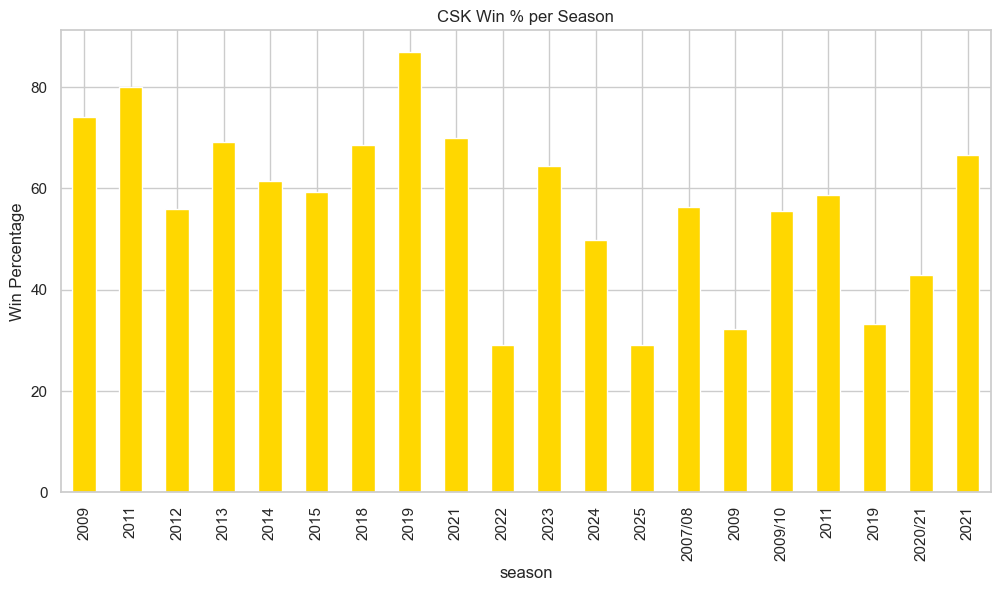

In [ ]:
# -------------------------------
# STEP 6: CSK MATCH PERFORMANCE
# -------------------------------

# 6.1 Season-wise wins and losses
if 'season' in df_csk.columns and 'match_won_by' in df_csk.columns:
    csk_wins = df_csk[df_csk['match_won_by']==CSK].groupby('season').size()
    total_matches = df_csk.groupby('season').size()
    win_rate = (csk_wins / total_matches) * 100

    plt.figure(figsize=(12,6))
    win_rate.plot(kind='bar', color='gold')
    plt.title("CSK Win % per Season")
    plt.ylabel("Win Percentage")
    plt.show()

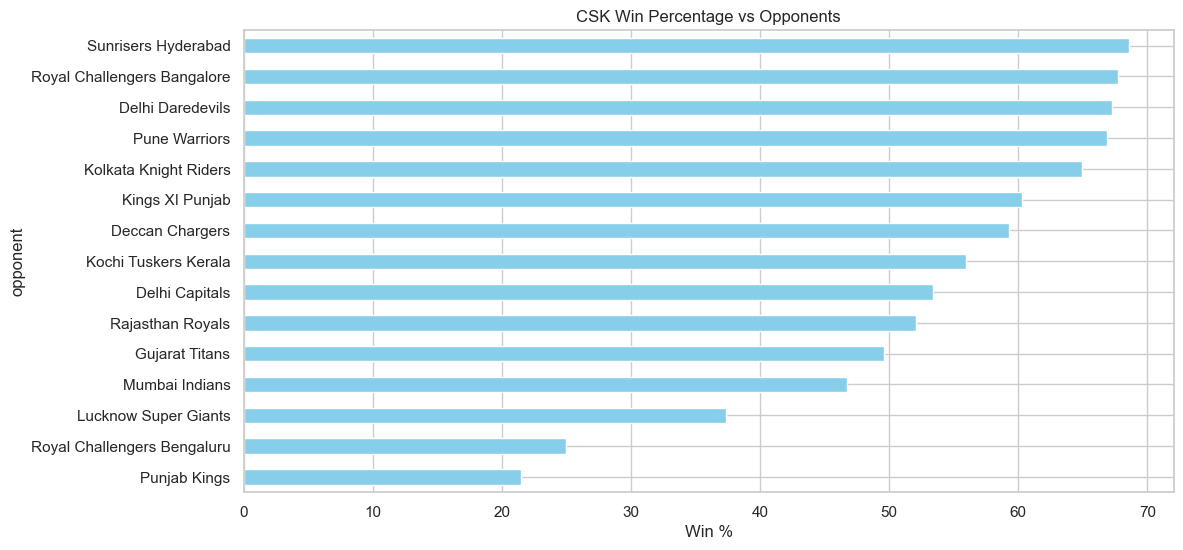

In [ ]:
# 6.2 Opponent-wise win rate
if 'match_won_by' in df_csk.columns and 'batting_team' in df_csk.columns:
    opponents = []
    for i, row in df_csk.iterrows():
        if row['batting_team'] == CSK:
            opponents.append(row['bowling_team'])
        else:
            opponents.append(row['batting_team'])
    df_csk['opponent'] = opponents

    win_counts = df_csk[df_csk['match_won_by']==CSK].groupby('opponent').size()
    total_counts = df_csk.groupby('opponent').size()
    opp_win_rate = (win_counts / total_counts) * 100

    plt.figure(figsize=(12,6))
    opp_win_rate.sort_values().plot(kind='barh', color='skyblue')
    plt.title("CSK Win Percentage vs Opponents")
    plt.xlabel("Win %")
    plt.show()


📌 Toss vs Match Result Table for CSK:


,Lost Match,Won Match
Lost Toss,14313,15564
Won Toss,11922,18807


<Figure size 800x600 with 0 Axes>

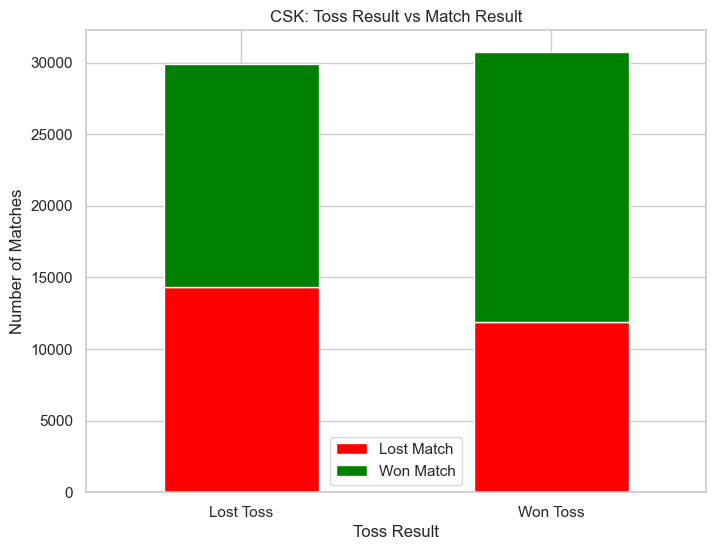

CSK Winning Probability when WON Toss: 61.20%
CSK Winning Probability when LOST Toss: 52.09%


In [ ]:
# -------------------------------
# STEP 7: TOSS VS MATCH RESULT DETAILED ANALYSIS
# -------------------------------
# Create a column to mark if CSK won the toss
df_csk['csk_toss_win'] = (df_csk['toss_winner'] == CSK).astype(int)

# Create a column to mark if CSK won the match
df_csk['csk_match_win'] = (df_csk['match_won_by'] == CSK).astype(int)

# Create a 2x2 contingency table
toss_match_matrix = pd.crosstab(df_csk['csk_toss_win'], df_csk['csk_match_win'])
toss_match_matrix.index = ['Lost Toss', 'Won Toss']
toss_match_matrix.columns = ['Lost Match', 'Won Match']

print("\n📌 Toss vs Match Result Table for CSK:")
display(toss_match_matrix)

# Plot stacked bar graph
plt.figure(figsize=(8,6))
toss_match_matrix.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8,6))
plt.title("CSK: Toss Result vs Match Result")
plt.xlabel("Toss Result")
plt.ylabel("Number of Matches")
plt.xticks(rotation=0)
plt.legend(['Lost Match', 'Won Match'])
plt.show()

# Calculate winning probabilities
toss_win_prob = toss_match_matrix.loc['Won Toss','Won Match'] / toss_match_matrix.loc['Won Toss'].sum() * 100
toss_loss_prob = toss_match_matrix.loc['Lost Toss','Won Match'] / toss_match_matrix.loc['Lost Toss'].sum() * 100

print(f"CSK Winning Probability when WON Toss: {toss_win_prob:.2f}%")
print(f"CSK Winning Probability when LOST Toss: {toss_loss_prob:.2f}%")


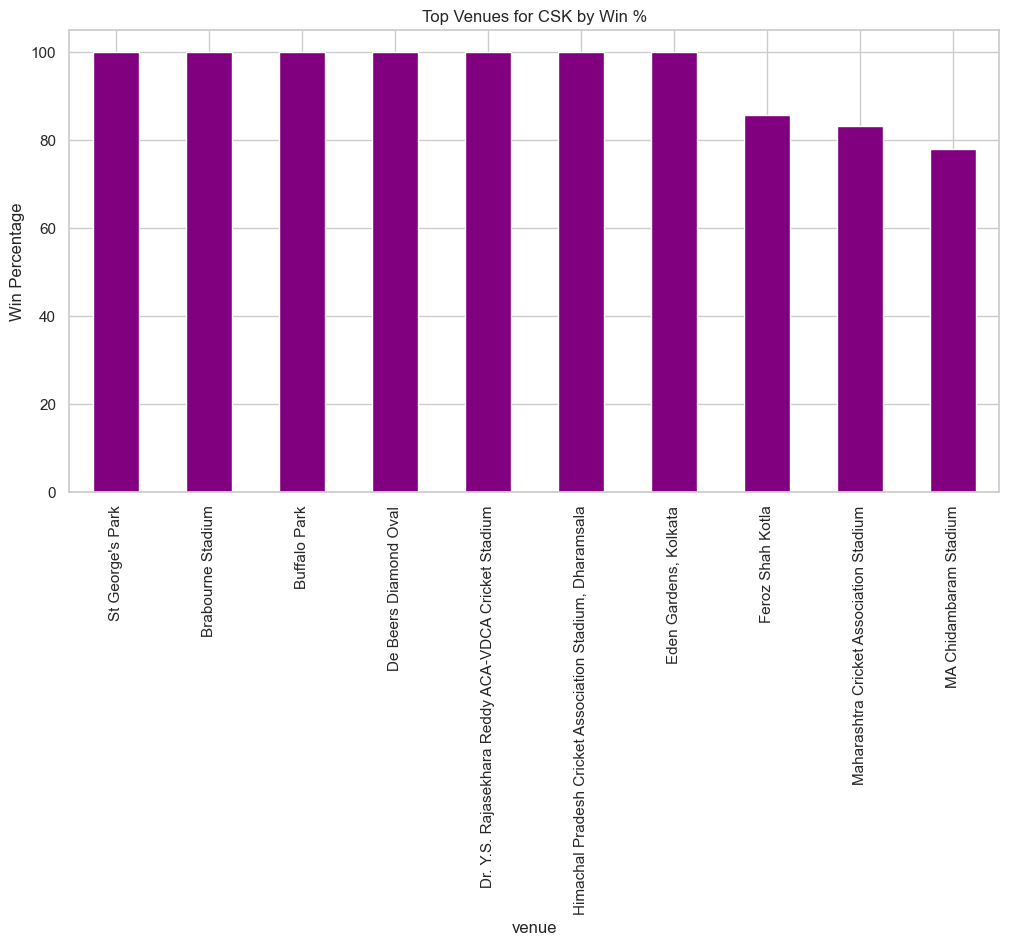

In [ ]:
# -------------------------------
# STEP 8: VENUE-WISE INSIGHTS
# -------------------------------
if 'venue' in df_csk.columns:
    venue_wins = df_csk[df_csk['match_won_by']==CSK].groupby('venue').size()
    venue_matches = df_csk.groupby('venue').size()
    venue_win_rate = (venue_wins / venue_matches) * 100

    plt.figure(figsize=(12,6))
    venue_win_rate.sort_values(ascending=False).head(10).plot(kind='bar', color='purple')
    plt.title("Top Venues for CSK by Win %")
    plt.ylabel("Win Percentage")
    plt.show()


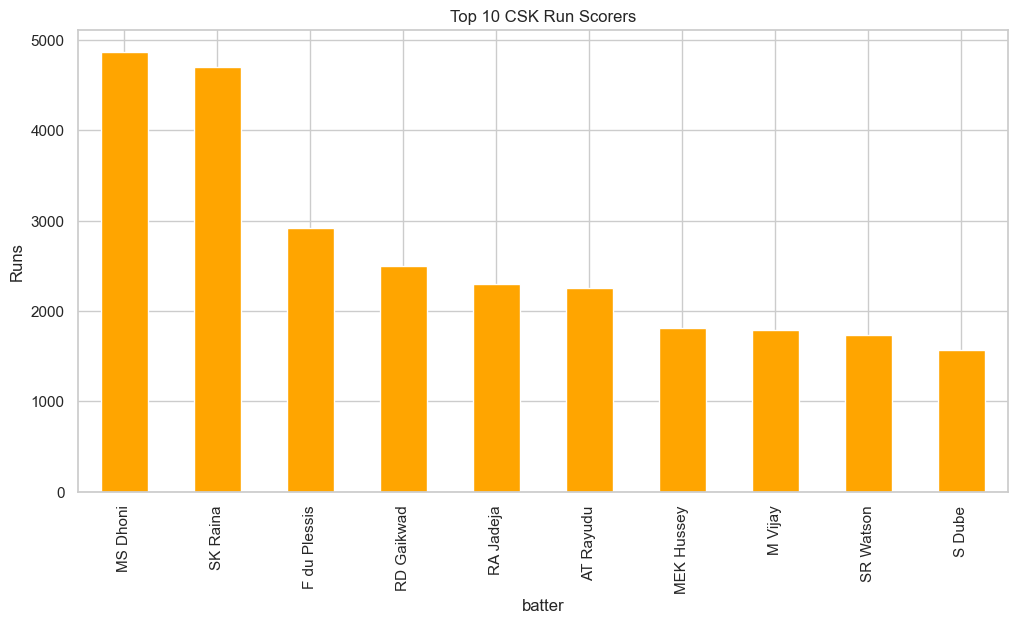

In [ ]:
# -------------------------------
# STEP 8: PLAYER PERFORMANCE ANALYSIS
# -------------------------------

# 8.1 Batting performance - top run scorers
if 'batter' in df_csk.columns and 'runs_batter' in df_csk.columns:
    top_batters = df_csk.groupby('batter')['runs_batter'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12,6))
    top_batters.plot(kind='bar', color='orange')
    plt.title("Top 10 CSK Run Scorers")
    plt.ylabel("Runs")
    plt.show()

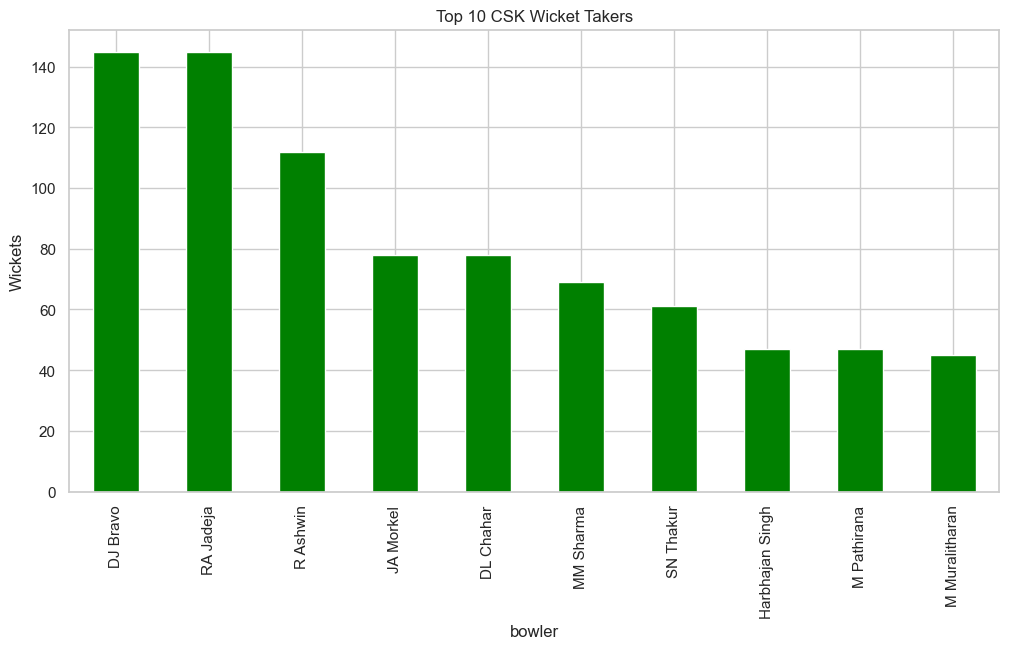

In [ ]:
# 8.2 Bowling performance - top wicket takers
if 'bowler' in df_csk.columns and 'bowler_wicket' in df_csk.columns:
    top_bowlers = df_csk.groupby('bowler')['bowler_wicket'].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(12,6))
    top_bowlers.plot(kind='bar', color='green')
    plt.title("Top 10 CSK Wicket Takers")
    plt.ylabel("Wickets")
    plt.show()

🔥 Top 5 CSK Batsmen: ['MS Dhoni', 'SK Raina', 'F du Plessis', 'RD Gaikwad', 'RA Jadeja']


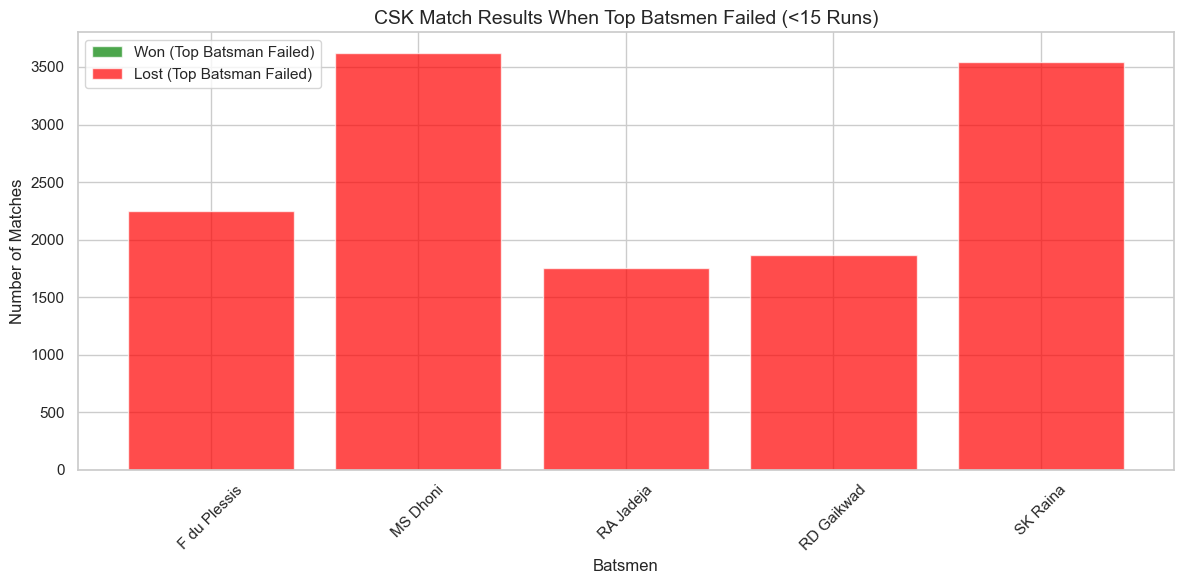

In [ ]:
# -------------------------------
# STEP 10: TOP BATSMEN FAILURE ANALYSIS
# -------------------------------
# Filter only CSK matches
csk_df = df[df['csk_involved'] == 1]

# Determine CSK match result using 'result_type' and 'superover_winner'
# If result_type == 'normal' and batting_team == winner, we set accordingly
csk_df['CSK_Won'] = csk_df.apply(
    lambda x: 'Won' if (x['batting_team'] == 'Chennai Super Kings' and x['result_type'] == 'normal') 
              or (x['superover_winner'] == 'Chennai Super Kings') 
              else 'Lost', axis=1
)

top_batsmen = (
    df_csk.groupby('batter')['runs_batter']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)
print("🔥 Top 5 CSK Batsmen:", top_batsmen)

# Filter only these top batsmen
top_csk_df = csk_df[csk_df['batter'].isin(top_batsmen)]

# Mark batsman failure if runs < 15
top_csk_df['batsman_failed'] = top_csk_df['runs_batter'] < 15

# Group data for wins/losses when top batsmen failed
fail_stats = (
    top_csk_df[top_csk_df['batsman_failed']]
    .groupby(['batter', 'CSK_Won'])
    .size()
    .unstack(fill_value=0)
)

# Ensure both Won & Lost columns exist
if 'Won' not in fail_stats.columns:
    fail_stats['Won'] = 0
if 'Lost' not in fail_stats.columns:
    fail_stats['Lost'] = 0

# Plot graph with two colors
plt.figure(figsize=(12, 6))
plt.bar(fail_stats.index, fail_stats['Won'], color='green', alpha=0.7, label='Won (Top Batsman Failed)')
plt.bar(fail_stats.index, fail_stats['Lost'], color='red', alpha=0.7, bottom=fail_stats['Won'], label='Lost (Top Batsman Failed)')

plt.title("CSK Match Results When Top Batsmen Failed (<15 Runs)", fontsize=14)
plt.xlabel("Batsmen", fontsize=12)
plt.ylabel("Number of Matches", fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


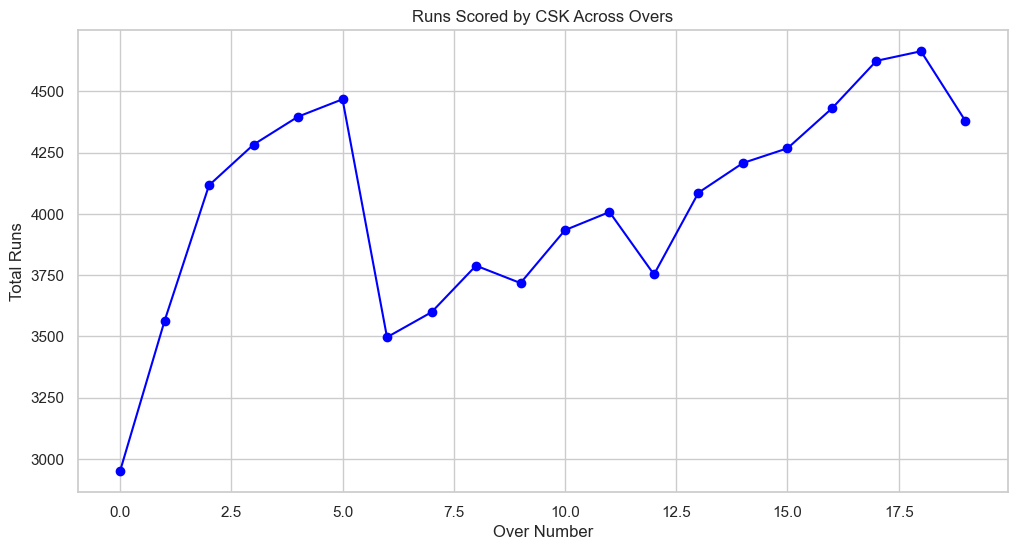

In [ ]:
# -------------------------------
# STEP 11: MATCH SITUATION ANALYSIS
# -------------------------------

# Runs distribution across overs
if 'over' in df_csk.columns and 'runs_total' in df_csk.columns:
    over_runs = df_csk.groupby('over')['runs_total'].sum()
    plt.figure(figsize=(12,6))
    over_runs.plot(kind='line', marker='o', color='blue')
    plt.title("Runs Scored by CSK Across Overs")
    plt.xlabel("Over Number")
    plt.ylabel("Total Runs")
    plt.show()

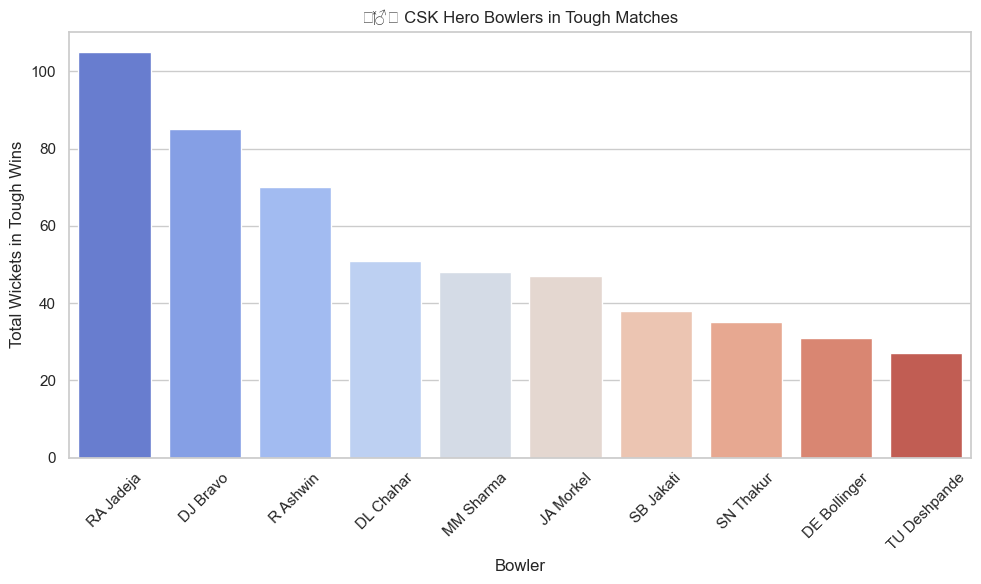

In [ ]:
# -------------------------------
# STEP 12: HERO BOWLERS ANALYSIS IN TOUGH MATCHES
# -------------------------------

# Calculate total runs by match
match_runs = csk_df.groupby(['match_id', 'batting_team'])['runs_total'].sum().reset_index()

# Pivot to get CSK_runs and Opponent_runs separately
match_runs_pivot = match_runs.pivot(index='match_id', columns='batting_team', values='runs_total').fillna(0)
match_runs_pivot['CSK_runs'] = match_runs_pivot.get('Chennai Super Kings', 0)
match_runs_pivot['Opponent_runs'] = match_runs_pivot.sum(axis=1) - match_runs_pivot['CSK_runs']

# Merge back into main dataframe
csk_df = csk_df.merge(match_runs_pivot[['CSK_runs', 'Opponent_runs']], on='match_id', how='left')

# Mark tough matches
csk_df['tough_match'] = csk_df.apply(
    lambda x: (
        (x['batting_team'] == 'Chennai Super Kings' and x['CSK_runs'] < 150) or
        (x['batting_team'] != 'Chennai Super Kings' and x['Opponent_runs'] >= 180)
    ), axis=1
)

# Mark matches CSK won
csk_df['CSK_Won'] = csk_df['match_won_by'].apply(lambda x: 'Won' if x == 'Chennai Super Kings' else 'Lost')

# Filter tough matches CSK won
tough_wins = csk_df[(csk_df['tough_match']) & (csk_df['CSK_Won'] == 'Won')]

# Count wickets taken by bowlers in tough matches CSK won
bowler_performance = tough_wins.groupby('bowler')['bowler_wicket'].sum().reset_index()
bowler_performance = bowler_performance.sort_values(by='bowler_wicket', ascending=False).head(10)

# Plot top 10 hero bowlers
plt.figure(figsize=(10,6))
sns.barplot(data=bowler_performance, x='bowler', y='bowler_wicket', palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel("Bowler")
plt.ylabel("Total Wickets in Tough Wins")
plt.title("🦸‍♂️ CSK Hero Bowlers in Tough Matches")
plt.tight_layout()
plt.show()

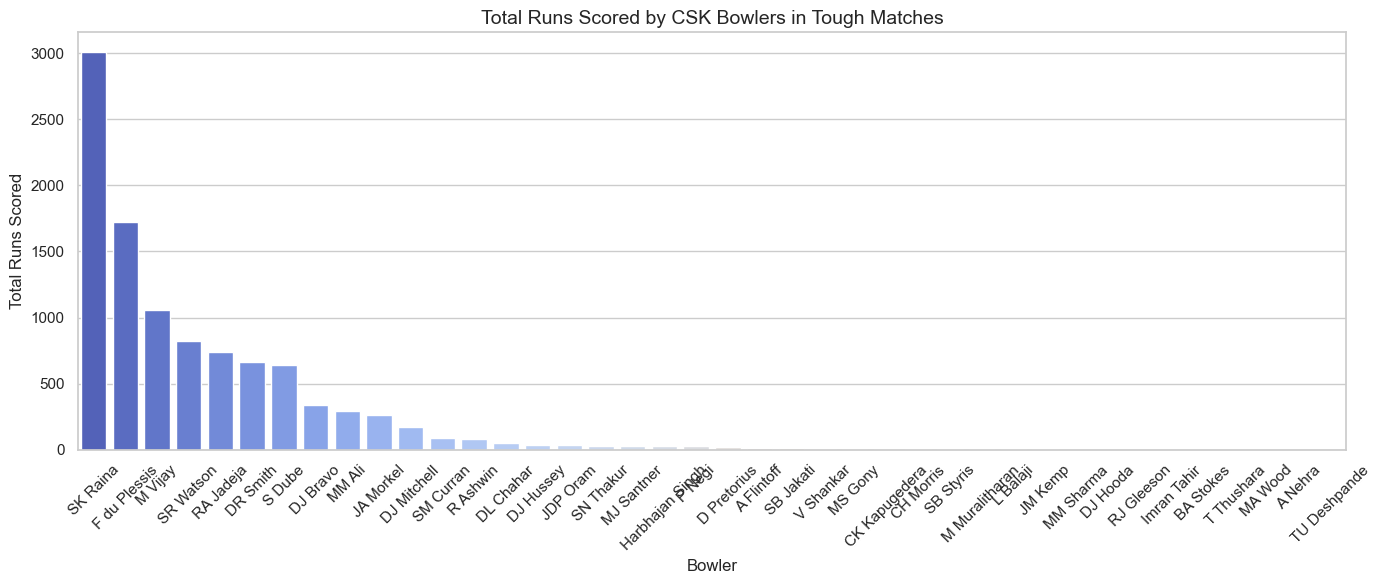

In [ ]:
# -------------------------------
# STEP 13: BOWLERS BATTING CONTRIBUTION IN TOUGH MATCHES
# -------------------------------

# Work on CSK dataframe (with match-level info)
csk_df = df[df['csk_involved'] == 1].copy()

# Relaxed "tough match" conditions
csk_df['tough_match'] = (
    ((csk_df['batting_team'] == 'Chennai Super Kings') & (csk_df['team_runs'] <= 170)) |
    ((csk_df['bowling_team'] == 'Chennai Super Kings') & (csk_df['runs_target'] >= 160))
)

# Filter tough matches CSK won
tough_wins = csk_df[(csk_df['tough_match']) & (csk_df['match_won_by'] == 'Chennai Super Kings')]

# List of CSK bowlers
csk_bowlers = tough_wins['bowler'].dropna().unique()

# Filter only cases where CSK bowlers batted in tough matches
bowler_batting = tough_wins[
    (tough_wins['batter'].isin(csk_bowlers)) & 
    (tough_wins['batting_team'] == 'Chennai Super Kings')
]

# Calculate total runs scored by CSK bowlers in tough matches
bowler_runs = bowler_batting.groupby('batter')['runs_batter'].sum().sort_values(ascending=False)

# Visualization
plt.figure(figsize=(14,6))
sns.barplot(x=bowler_runs.index, y=bowler_runs.values, palette="coolwarm")
plt.title("Total Runs Scored by CSK Bowlers in Tough Matches", fontsize=14)
plt.xlabel("Bowler", fontsize=12)
plt.ylabel("Total Runs Scored", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

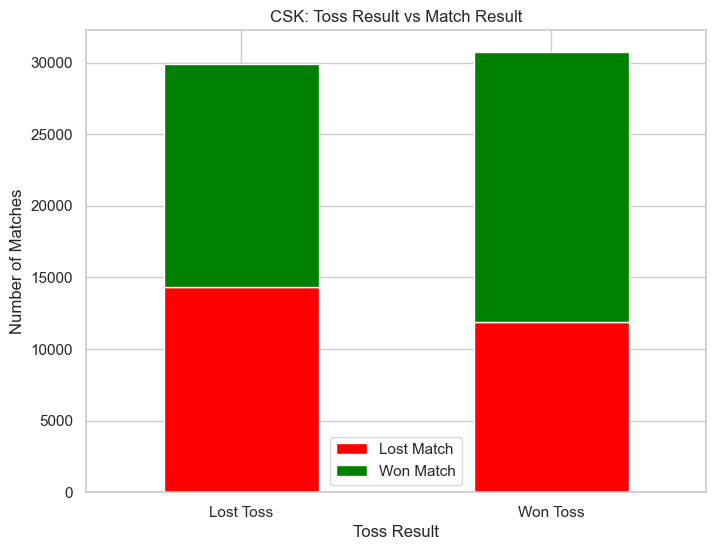

CSK Winning Probability when WON Toss: 61.20%
CSK Winning Probability when LOST Toss: 52.09%


In [ ]:
# Plot stacked bar graph
plt.figure(figsize=(8,6))
toss_match_matrix.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8,6))
plt.title("CSK: Toss Result vs Match Result")
plt.xlabel("Toss Result")
plt.ylabel("Number of Matches")
plt.xticks(rotation=0)
plt.legend(['Lost Match', 'Won Match'])
plt.show()
# Calculate winning probabilities
toss_win_prob = toss_match_matrix.loc['Won Toss','Won Match'] / toss_match_matrix.loc['Won Toss'].sum() * 100
toss_loss_prob = toss_match_matrix.loc['Lost Toss','Won Match'] / toss_match_matrix.loc['Lost Toss'].sum() * 100

print(f"CSK Winning Probability when WON Toss: {toss_win_prob:.2f}%")
print(f"CSK Winning Probability when LOST Toss: {toss_loss_prob:.2f}%")

In [ ]:
# -----------------------------------------------
# EXTRA ANALYSIS: CSK Toss Result vs Match Result
# -----------------------------------------------

# Create a column to mark if CSK won the toss
df_csk['csk_toss_win'] = (df_csk['toss_winner'] == CSK).astype(int)

# Create a column to mark if CSK won the match
df_csk['csk_match_win'] = (df_csk['match_won_by'] == CSK).astype(int)

# Create a 2x2 contingency table
toss_match_matrix = pd.crosstab(df_csk['csk_toss_win'], df_csk['csk_match_win'])
toss_match_matrix.index = ['Lost Toss', 'Won Toss']
toss_match_matrix.columns = ['Lost Match', 'Won Match']

print("\n📌 Toss vs Match Result Table for CSK:")
display(toss_match_matrix)



📌 Toss vs Match Result Table for CSK:


,Lost Match,Won Match
Lost Toss,14313,15564
Won Toss,11922,18807


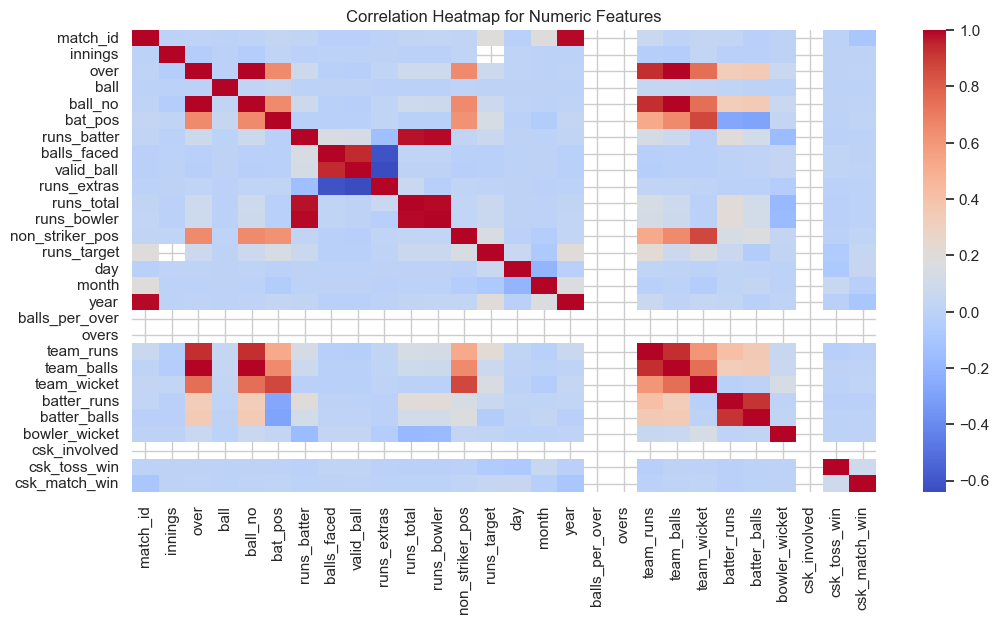

In [ ]:
# -------------------------------
# STEP 14: CORRELATION HEATMAP
# -------------------------------
numeric_cols = df_csk.select_dtypes(include=np.number)
plt.figure(figsize=(12,6))
sns.heatmap(numeric_cols.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap for Numeric Features")
plt.show()


Outlier Diagnostics (IQR method):
  runs_batter: samples=60606, outliers=10027 (16.54%)


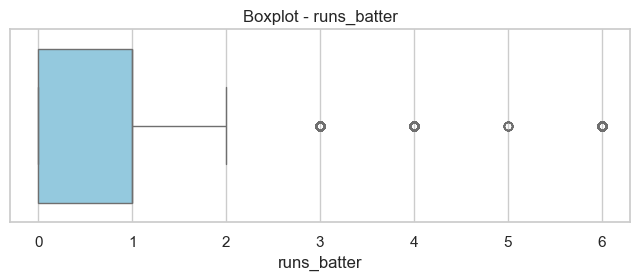

  bowler_wicket: samples=60606, outliers=2674 (4.41%)


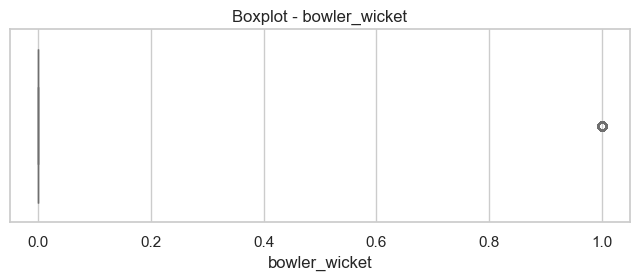

  team_runs: samples=60606, outliers=25 (0.04%)


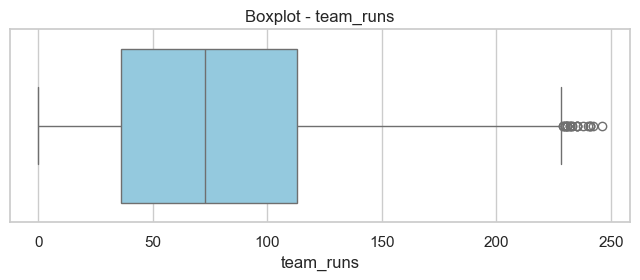

  team_wicket: samples=60606, outliers=548 (0.90%)


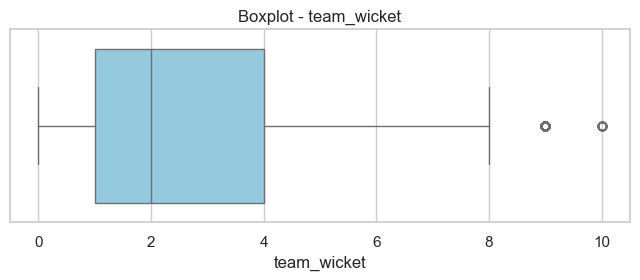

In [ ]:
# -------------------------------
# STEP 15: OUTLIER ANALYSIS (BOXPLOTS)
# -------------------------------
numeric_outlier_candidates = [c for c in ['runs_batter','bowler_wicket','team_runs','team_wicket'] if c in df_csk.columns]

def iqr_outlier_info(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

print("\nOutlier Diagnostics (IQR method):")
for col in numeric_outlier_candidates:
    s = df_csk[col].dropna()
    if s.empty: 
        continue
    lower, upper = iqr_outlier_info(s)
    outliers = s[(s < lower) | (s > upper)]
    print(f"  {col}: samples={len(s)}, outliers={len(outliers)} ({len(outliers)/len(s):.2%})")
    plt.figure(figsize=(8,2.5))
    sns.boxplot(x=s, color='skyblue')
    plt.title(f"Boxplot - {col}")
    plt.show()


In [ ]:
# -------------------------------
# STEP 16: EDA SUMMARY
# -------------------------------
print("✅ Advanced EDA Completed!")
print("Insights gathered about:")
print("- Season-wise performance")
print("- Opponent analysis")
print("- Venue-based strengths")
print("- Player contributions")
print("- Match situation trends")

✅ Advanced EDA Completed!
Insights gathered about:
- Season-wise performance
- Opponent analysis
- Venue-based strengths
- Player contributions
- Match situation trends


In [ ]:
# -------------------------------
# STEP 17: PREPARE DATA FOR MODELING
# -------------------------------

# Work only on CSK-involved matches
model_df = df[df['csk_involved'] == 1].copy()

# Create target variable (did CSK win?)
model_df['CSK_Win'] = (model_df['match_won_by'] == "Chennai Super Kings").astype(int)

# Derive opponent column
model_df['opponent'] = model_df.apply(
    lambda x: x['bowling_team'] if x['batting_team'] == "Chennai Super Kings" else x['batting_team'], axis=1
)

# Clean season column → first 4 digits as integer
model_df['season'] = model_df['season'].astype(str).str[:4].astype(int)

# Select useful features
features = ['season', 'venue', 'opponent', 'toss_winner', 'toss_decision', 
            'runs_target', 'team_runs', 'team_wicket']
X = model_df[features].copy()
y = model_df['CSK_Win']

# Handle missing values
for col in ['runs_target', 'team_runs', 'team_wicket', 'season']:
    X[col] = X[col].fillna(X[col].median())   # numeric → median

for col in ['venue', 'opponent', 'toss_winner', 'toss_decision']:
    X[col] = X[col].fillna(X[col].mode()[0]) # categorical → mode
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


In [ ]:
# -------------------------------
# STEP 18: LOGISTIC REGRESSION
# -------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)
y_prob_log = log_reg.predict_proba(X_test_scaled)[:,1]

print("📌 Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))


📌 Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.56      0.23      0.32      5247
           1       0.59      0.86      0.70      6875

    accuracy                           0.59     12122
   macro avg       0.58      0.55      0.51     12122
weighted avg       0.58      0.59      0.54     12122

ROC-AUC: 0.5781344006098723


In [ ]:
# -------------------------------
# STEP 19: RANDOM FOREST
# -------------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\n📌 Random Forest Results:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))



📌 Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5247
           1       1.00      1.00      1.00      6875

    accuracy                           1.00     12122
   macro avg       1.00      1.00      1.00     12122
weighted avg       1.00      1.00      1.00     12122

ROC-AUC: 0.9999220056482492


In [ ]:
# -------------------------------
# STEP 20: XGBOOST
# -------------------------------
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:,1]

print("\n📌 XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))



📌 XGBoost Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5247
           1       1.00      1.00      1.00      6875

    accuracy                           1.00     12122
   macro avg       1.00      1.00      1.00     12122
weighted avg       1.00      1.00      1.00     12122

ROC-AUC: 0.9999959388048583


,Model,Accuracy,F1-Score,ROC-AUC
0,Logistic Regression,0.588187,0.704195,0.578134
1,Random Forest,0.999423,0.999491,0.999922
2,XGBoost,0.998763,0.998909,0.999996


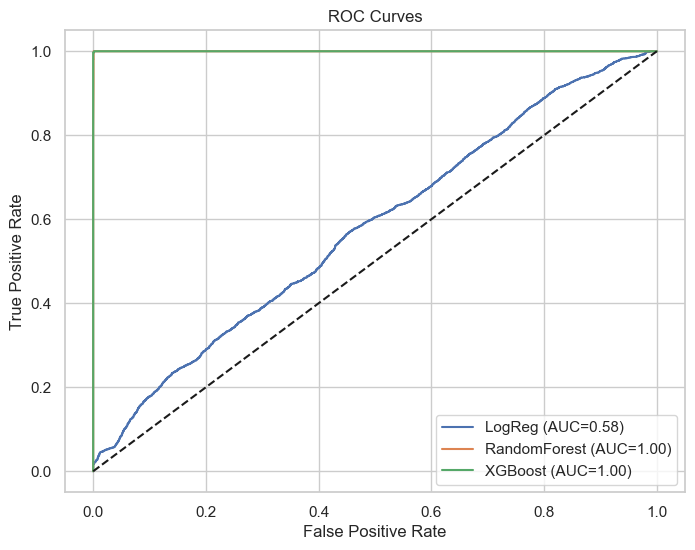

In [ ]:
# -------------------------------
# STEP 21: MODEL COMPARISON
# -------------------------------
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_prob_log),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ]
})
display(results)

# Plot ROC Curves
plt.figure(figsize=(8,6))
for model_name, y_prob in [("LogReg", y_prob_log), ("RandomForest", y_prob_rf), ("XGBoost", y_prob_xgb)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_test,y_prob):.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


In [ ]:
# -------------------------------
# STEP 22: CROSS-VALIDATION CHECK
# -------------------------------
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("\nCross-validation (5-fold) Accuracy:")
for name, model, X_train_fit, y_train_fit in [
    ("Logistic Regression", log_reg, X_train_scaled, y_train),
    ("Random Forest", rf, X_train, y_train),
    ("XGBoost", xgb_model, X_train, y_train)
]:
    scores = cross_val_score(model, X_train_fit, y_train_fit, cv=cv, scoring='accuracy')
    print(f"  {name}: mean={scores.mean():.4f}, std={scores.std():.4f}")



Cross-validation (5-fold) Accuracy:
  Logistic Regression: mean=0.5800, std=0.0018
  Random Forest: mean=0.9991, std=0.0003
  XGBoost: mean=0.9992, std=0.0002


In [ ]:
# -------------------------------
# STEP 23: TRAIN-TEST GAP CHECK (OVERFITTING/UNDERFITTING)
# -------------------------------
def train_test_gap(model, X_tr, X_te, y_tr, y_te, name):
    train_score = model.score(X_tr, y_tr)
    test_score = model.score(X_te, y_te)
    print(f"{name}: train={train_score:.4f}, test={test_score:.4f}, gap={(train_score-test_score):.4f}")

print("\nTrain-Test Score Gaps:")
train_test_gap(log_reg, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
train_test_gap(rf, X_train, X_test, y_train, y_test, "Random Forest")
train_test_gap(xgb_model, X_train, X_test, y_train, y_test, "XGBoost")



Train-Test Score Gaps:
Logistic Regression: train=0.5817, test=0.5882, gap=-0.0065
Random Forest: train=0.9997, test=0.9994, gap=0.0003
XGBoost: train=0.9995, test=0.9988, gap=0.0007


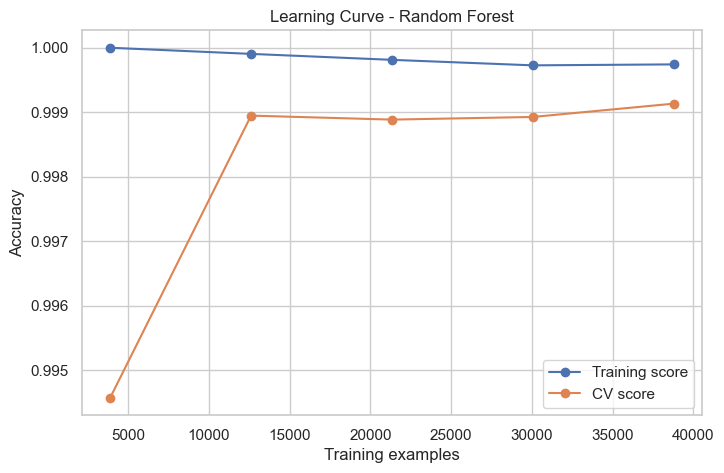

In [ ]:
# -------------------------------
# STEP 24: LEARNING CURVE (RANDOM FOREST EXAMPLE)
# -------------------------------
plt.figure(figsize=(8,5))
train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=cv, scoring='accuracy',
    train_sizes=np.linspace(0.1,1.0,5), random_state=RANDOM_STATE
)
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', label='CV score')
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

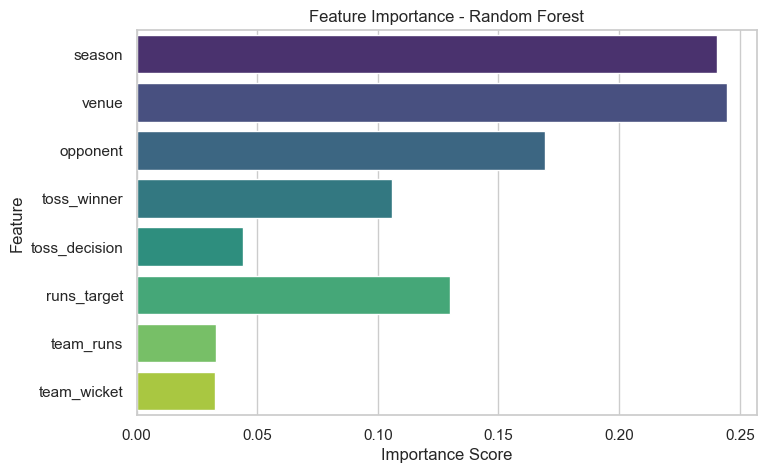

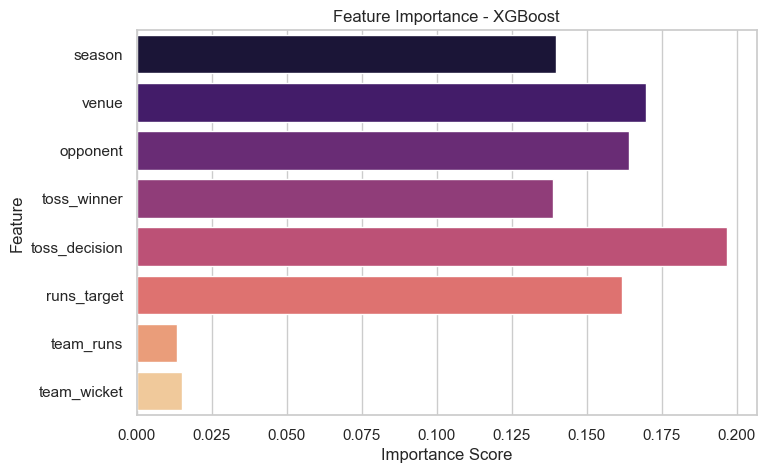

✅ Feature importance plotted for Random Forest and XGBoost
✅ Complete CSK IPL Analysis Pipeline Finished!


In [ ]:
# -------------------------------
# STEP 25: FEATURE IMPORTANCE (TREE MODELS)
# -------------------------------
importances_rf = rf.feature_importances_
importances_xgb = xgb_model.feature_importances_

feat_names = X.columns

# Random Forest
plt.figure(figsize=(8,5))
sns.barplot(x=importances_rf, y=feat_names, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# XGBoost
plt.figure(figsize=(8,5))
sns.barplot(x=importances_xgb, y=feat_names, palette="magma")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("✅ Feature importance plotted for Random Forest and XGBoost")
print("✅ Complete CSK IPL Analysis Pipeline Finished!")

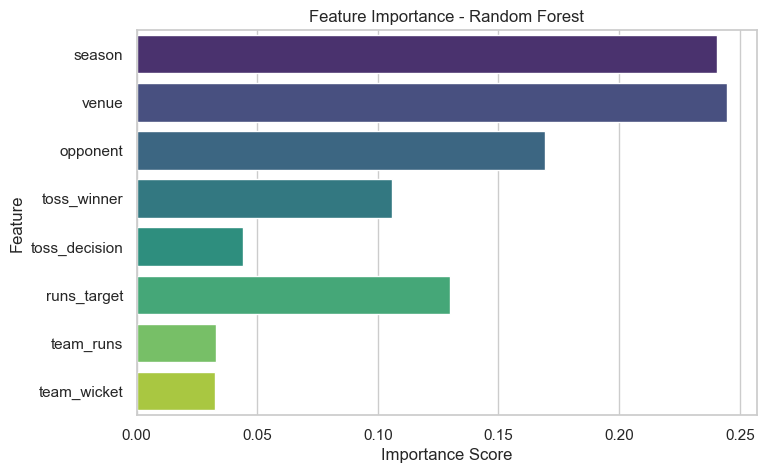

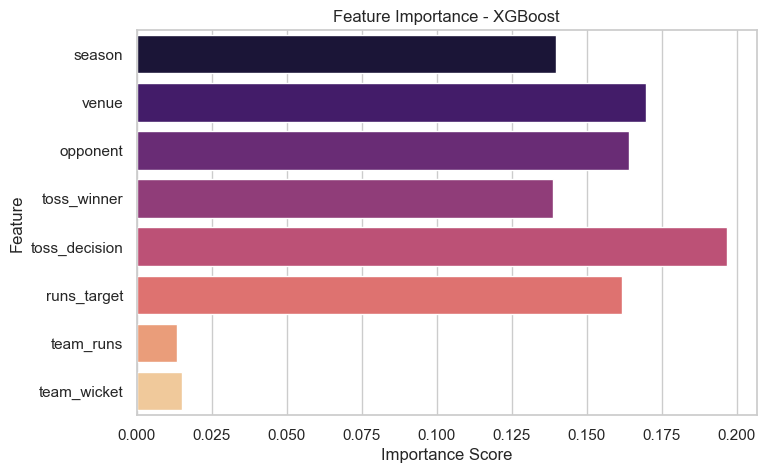

✅ Feature importance plotted for Random Forest and XGBoost


In [ ]:
# -------------------------------
# STEP 21: FEATURE IMPORTANCE (Tree Models)
# -------------------------------
importances_rf = rf.feature_importances_
importances_xgb = xgb_model.feature_importances_

feat_names = X.columns

# Random Forest
plt.figure(figsize=(8,5))
sns.barplot(x=importances_rf, y=feat_names, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# XGBoost
plt.figure(figsize=(8,5))
sns.barplot(x=importances_xgb, y=feat_names, palette="magma")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

print("✅ Feature importance plotted for Random Forest and XGBoost")


In [ ]:
# Save final processed dataset
csk_df.to_csv(r"C:\Users\Devraj Singh\Desktop\ml project\CSK_final_processed.csv", index=False)

print("✅ Final processed dataset saved as CSK_final_processed.csv")


✅ Final processed dataset saved as CSK_final_processed.csv


In [ ]:
model_df.to_csv(r"C:\Users\Devraj Singh\Desktop\ml project\CSK_modeling_data.csv", index=False)

print("✅ Modeling dataset saved as CSK_modeling_data.csv")


✅ Modeling dataset saved as CSK_modeling_data.csv


In [ ]:
# Example: Predict CSK's chances in a new match
new_match = pd.DataFrame({
    'season': [2025],
    'venue': [1],  # Encoded venue
    'opponent': [5],  # Encoded opponent 
    'toss_winner': [1],  # Encoded toss winner
    'toss_decision': [0],  # Encoded decision
    'runs_target': [180],
    'team_runs': [160], 
    'team_wicket': [7]
})

# Predictions
rf_prediction = rf.predict(new_match)[0]  # 0 = Loss, 1 = Win
rf_probability = rf.predict_proba(new_match)[0,1]  # Win probability

print(f"CSK Win Prediction: {'YES' if rf_prediction == 1 else 'NO'}")
print(f"Win Probability: {rf_probability:.2%}")

CSK Win Prediction: YES
Win Probability: 56.00%


In [ ]:
# -------------------------------
# STEP A: MATCH-LEVEL PRE-MATCH DATA (LEAKAGE-FREE)
# -------------------------------
CSK = "Chennai Super Kings"

# Keep only rows from matches where CSK is involved
df_matches = df.copy()
if 'csk_involved' not in df_matches.columns:
    df_matches['csk_involved'] = ((df_matches.get('batting_team') == CSK) | (df_matches.get('bowling_team') == CSK)).astype(int)

# Build one row per match_id (pre-match static info only)
# For opponent, find the unique non-CSK team appearing in that match
pre_match_rows = []
for match_id, g in df_matches[df_matches['csk_involved'] == 1].groupby('match_id'):
    teams = set(pd.concat([g['batting_team'].dropna().unique(), g['bowling_team'].dropna().unique()]))
    opponent = next((t for t in teams if t != CSK), np.nan)
    row = {
        'match_id': match_id,
        'season': str(g['season'].iloc[0])[:4],
        'venue': g['venue'].dropna().iloc[0] if 'venue' in g.columns and g['venue'].notna().any() else np.nan,
        'city': g['city'].dropna().iloc[0] if 'city' in g.columns and g['city'].notna().any() else np.nan,
        'stage': g['stage'].dropna().iloc[0] if 'stage' in g.columns and g['stage'].notna().any() else np.nan,
        'match_number': g['match_number'].dropna().iloc[0] if 'match_number' in g.columns and g['match_number'].notna().any() else np.nan,
        'opponent': opponent,
        # optional post-toss features (commented out for pure pre-match)
        'toss_winner': g['toss_winner'].dropna().iloc[0] if 'toss_winner' in g.columns and g['toss_winner'].notna().any() else np.nan,
        'toss_decision': g['toss_decision'].dropna().iloc[0] if 'toss_decision' in g.columns and g['toss_decision'].notna().any() else np.nan,
        # target
        'CSK_Win': 1 if ('match_won_by' in g.columns and (g['match_won_by'] == CSK).any()) else 0,
    }
    pre_match_rows.append(row)

match_level_df = pd.DataFrame(pre_match_rows)

# Clean and type-cast
match_level_df['season'] = pd.to_numeric(match_level_df['season'], errors='coerce')

# Choose feature sets
prematch_features = ['season', 'venue', 'city', 'stage', 'match_number', 'opponent']  # leakage-free pre-match
post_toss_features = prematch_features + ['toss_winner', 'toss_decision']  # optional scenario

# Select which scenario to train (set use_post_toss = False for pure pre-match)
use_post_toss = False
feature_cols = post_toss_features if use_post_toss else prematch_features

# Handle missing values minimally before pipeline (mostly for season)
match_level_df['match_number'] = pd.to_numeric(match_level_df['match_number'], errors='coerce')

ml_df = match_level_df.copy()
X_all = ml_df[feature_cols]
y_all = ml_df['CSK_Win']

print(f"Match-level rows: {len(ml_df)} | Positive rate: {y_all.mean():.2f}")


In [ ]:
# -------------------------------
# STEP B: TEMPORAL TRAIN/TEST SPLIT BY SEASON
# -------------------------------
# Choose a cutoff season; train on <= cutoff, test on > cutoff
cutoff_season = int(np.nanpercentile(match_level_df['season'].dropna(), 70))  # 70th percentile season as cutoff
train_mask = match_level_df['season'] <= cutoff_season

test_mask = match_level_df['season'] > cutoff_season

X_train_ml = X_all[train_mask]
X_test_ml  = X_all[test_mask]
y_train_ml = y_all[train_mask]
y_test_ml  = y_all[test_mask]

print(f"Cutoff season: {cutoff_season}")
print(f"Train: {X_train_ml.shape}, Test: {X_test_ml.shape}")

# Fallback: if test becomes empty (e.g., all seasons same), use GroupShuffleSplit by match_id
if len(X_test_ml) == 0:
    from sklearn.model_selection import GroupShuffleSplit
    gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    groups = ml_df['match_id']
    tr_idx, te_idx = next(gss.split(X_all, y_all, groups))
    X_train_ml, X_test_ml = X_all.iloc[tr_idx], X_all.iloc[te_idx]
    y_train_ml, y_test_ml = y_all.iloc[tr_idx], y_all.iloc[te_idx]
    print("Used GroupShuffleSplit fallback due to empty temporal test set")


In [ ]:
# -------------------------------
# STEP C: PREPROCESSING PIPELINES & MODELS
# -------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

numeric_features = ['season', 'match_number']
categorical_features = [c for c in feature_cols if c not in numeric_features]

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ], remainder='drop'
)

logreg_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
])

rf_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE))
])

xgb_clf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', xgb.XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        tree_method='hist'
    ))
])

models = {
    'Logistic Regression': logreg_clf,
    'Random Forest': rf_clf,
    'XGBoost': xgb_clf,
}

fitted = {}
for name, pipe in models.items():
    pipe.fit(X_train_ml, y_train_ml)
    fitted[name] = pipe
print("Models trained.")


In [ ]:
# -------------------------------
# STEP D: EVALUATION (VALID METRICS & ROC)
# -------------------------------
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, f1_score

results_rows = []
plt.figure(figsize=(8,6))
for name, pipe in fitted.items():
    y_pred = pipe.predict(X_test_ml)
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        y_prob = pipe.predict_proba(X_test_ml)[:,1]
    else:
        # fallback for models without predict_proba
        y_prob = pipe.decision_function(X_test_ml)
        # scale to 0-1 if needed
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min() + 1e-9)

    print(f"\n📌 {name} Results (Temporal Split):")
    print(classification_report(y_test_ml, y_pred))
    auc = roc_auc_score(y_test_ml, y_prob)
    acc = accuracy_score(y_test_ml, y_pred)
    f1 = f1_score(y_test_ml, y_pred)
    results_rows.append({'Model': name, 'Accuracy': acc, 'F1-Score': f1, 'ROC-AUC': auc})

    fpr, tpr, _ = roc_curve(y_test_ml, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Temporal Test Set")
plt.legend()
plt.show()

results_df = pd.DataFrame(results_rows)
display(results_df.sort_values('ROC-AUC', ascending=False))


In [ ]:
# -------------------------------
# STEP E: SAVE MATCH-LEVEL DATASET (OPTIONAL)
# -------------------------------
output_path = r"C:\Users\Devraj Singh\Desktop\ml project\CSK_match_level_prematch.csv"
ml_df.to_csv(output_path, index=False)
print(f"✅ Saved match-level pre-match dataset to: {output_path}")


In [ ]:
# -------------------------------
# STEP F: SELECT BEST MODEL AND PERSIST
# -------------------------------
import json, joblib, time
from pathlib import Path

artifacts_dir = Path(r"C:\Users\Devraj Singh\Desktop\ml project\artifacts")
artifacts_dir.mkdir(parents=True, exist_ok=True)

# Choose best by ROC-AUC (from results_df in Step D)
best_row = results_df.sort_values('ROC-AUC', ascending=False).iloc[0]
best_name = best_row['Model']
best_model = fitted[best_name]

model_path = artifacts_dir / f"csk_prematch_{best_name.replace(' ','_').lower()}.pkl"
joblib.dump({
    'pipeline': best_model,
    'feature_cols': feature_cols,
    'use_post_toss': use_post_toss,
    'cutoff_season': int(match_level_df['season'].dropna().quantile(0.7)),
    'created_at': int(time.time())
}, model_path)

print(f"✅ Saved best model: {best_name} -> {model_path}")


In [ ]:
# -------------------------------
# STEP G: INFERENCE HELPER (PRE-MATCH)
# -------------------------------
import joblib

def load_model(model_file):
    obj = joblib.load(model_file)
    return obj['pipeline'], obj

best_model_file = str(model_path)  # from Step F
pipeline, meta = load_model(best_model_file)

# Example: pre-match input (no toss info)
example_input = pd.DataFrame({
    'season': [2025],
    'venue': ['MA Chidambaram Stadium, Chepauk'],
    'city': ['Chennai'],
    'stage': ['league'],
    'match_number': [10],
    'opponent': ['Mumbai Indians']
})

pred_proba = pipeline.predict_proba(example_input)[:,1][0]
pred_label = int(pred_proba >= 0.5)
print(f"Win probability: {pred_proba:.2%} | Predict Win: {bool(pred_label)}")


In [ ]:
# -------------------------------
# STEP H: MODEL CARD (LIGHTWEIGHT)
# -------------------------------
from datetime import datetime

model_card = {
    'project': 'CSK IPL Performance - Pre-match Win Probability',
    'model_name': best_name,
    'created_at': datetime.utcfromtimestamp(meta['created_at']).isoformat() + 'Z',
    'features': feature_cols,
    'use_post_toss': use_post_toss,
    'training_rows': int(len(X_train_ml)),
    'test_rows': int(len(X_test_ml)),
    'temporal_cutoff_season': int(meta['cutoff_season']),
    'metrics_temporal_test': {
        'accuracy': float(results_df.set_index('Model').loc[best_name, 'Accuracy']),
        'f1_score': float(results_df.set_index('Model').loc[best_name, 'F1-Score']),
        'roc_auc': float(results_df.set_index('Model').loc[best_name, 'ROC-AUC'])
    }
}

card_path = artifacts_dir / 'model_card.json'
with open(card_path, 'w', encoding='utf-8') as f:
    json.dump(model_card, f, indent=2)
print(f"✅ Saved model card -> {card_path}")


In [ ]:
# -------------------------------
# STEP I: DATASET HEALTH CHECKS (IPL.csv)
# -------------------------------
from collections import defaultdict

print("Basic shape:", df.shape)
print("Distinct matches:", df['match_id'].nunique())

# Missingness summary (top 20 by missing%)
miss_pct = df.isna().mean().sort_values(ascending=False)
print("\nMissingness (% of rows missing) - top 20:\n", (miss_pct.head(20)*100).round(2))

# Season vs date year consistency (where available)
if 'date' in df.columns:
    df['_date'] = pd.to_datetime(df['date'], errors='coerce')
    df['_year_from_date'] = df['_date'].dt.year
    mismatch = (df['_year_from_date'].notna()) & (df['season'].astype(str).str[:4] != df['_year_from_date'].astype('Int64').astype(str))
    print("\nRows with season vs date.year mismatch:", int(mismatch.sum()))

# Innings totals consistency per match
issues = 0
check_samples = 0
for mid, g in df.groupby('match_id'):
    # compute first innings total
    inns = g.groupby('innings')['runs_total'].sum().sort_index()
    if 1 in inns.index:
        first_total = inns.loc[1]
        # runs_target should be first_total + 1 for chasing innings rows
        if 'runs_target' in g.columns:
            ch_mask = g['innings'] == 2
            if ch_mask.any():
                # allow some NaNs; check where present
                target_vals = g.loc[ch_mask, 'runs_target'].dropna().unique()
                if len(target_vals) > 0:
                    expected = first_total + 1
                    if not all(target_vals == expected):
                        issues += 1
    check_samples += 1

print(f"\nTarget consistency issues (by match): {issues} over {check_samples} checked")

# Team name normalization sanity
for col in ['batting_team','bowling_team','toss_winner','match_won_by']:
    if col in df.columns:
        uniq = pd.Series(sorted(df[col].dropna().unique()))
        print(f"\n{col}: unique values = {len(uniq)}")
        print(uniq.head(20).to_list())

# Cleanup temp columns
for c in ['_date','_year_from_date']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)


In [ ]:
# -------------------------------
# STEP J: MODEL CALIBRATION (Platt scaling) AND SAVE VERSIONED ARTIFACT
# -------------------------------
from sklearn.calibration import CalibratedClassifierCV
import joblib
from pathlib import Path

# Use the best pipeline from Step F (best_model) and calibrate it
# Wrap the entire pipeline for calibration
calibrated = CalibratedClassifierCV(base_estimator=best_model, method='sigmoid', cv=5)
calibrated.fit(X_train_ml, y_train_ml)

# Evaluate calibrated model
from sklearn.metrics import brier_score_loss
if hasattr(calibrated, 'predict_proba'):
    y_prob_cal = calibrated.predict_proba(X_test_ml)[:,1]
else:
    y_dec = calibrated.decision_function(X_test_ml)
    y_prob_cal = (y_dec - y_dec.min()) / (y_dec.max() - y_dec.min() + 1e-9)

auc_cal = roc_auc_score(y_test_ml, y_prob_cal)
bs_cal = brier_score_loss(y_test_ml, y_prob_cal)
print(f"Calibrated AUC: {auc_cal:.4f} | Brier: {bs_cal:.4f}")

# Save versioned artifact (semantic version bump)
version = '1.1.0'
artifacts_dir = Path(r"C:\Users\Devraj Singh\Desktop\ml project\artifacts")
versioned_path = artifacts_dir / f"csk_prematch_calibrated_v{version}.pkl"
joblib.dump({
    'pipeline': calibrated,
    'feature_cols': feature_cols,
    'use_post_toss': use_post_toss,
    'created_at': int(time.time()),
    'version': version,
    'base_model_name': best_name,
}, versioned_path)

# Update model_card with calibration metrics
model_card['version'] = version
model_card['calibrated'] = True
model_card['metrics_temporal_test_calibrated'] = {
    'roc_auc': float(auc_cal),
    'brier': float(bs_cal)
}
with open(card_path, 'w', encoding='utf-8') as f:
    json.dump(model_card, f, indent=2)
print(f"✅ Saved calibrated model -> {versioned_path}")

# Pointer to latest
latest_ptr = artifacts_dir / 'latest.txt'
latest_ptr.write_text(versioned_path.name, encoding='utf-8')
print(f"Updated latest pointer -> {latest_ptr}")
